# Create Simple ML Model

On this notebook we will create a base model using a simple machine learning algorithm and training it without the spatial data. This will be our baseline model to compare with the more complex models that will be created later.

The data we will use contains the following information:
- Porcentage of votes for each important party for each election held in Catalonia.
- The socio-economic index for each censal section in Catalonia.
- The age groups for each censal section in Catalonia.
- The proportion of born abroad for each censal section in Catalonia.

## Load data

First, we will load the libraries.

In [1]:
import re
import pandas as pd
import geopandas as gpd
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
import pysal as ps
import contextily
from splot.esda import plot_moran
from pysal.viz import splot
from unidecode import unidecode
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed
from sklearn.model_selection import train_test_split
from typing import Tuple, List

pp = pprint.PrettyPrinter(indent=2)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

c:\Users\guill\Documents\code\catalan-elections-data\.venv\Lib\site-packages\spaghetti\network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


Now, we load the the dataset.

In [2]:
# data = gpd.read_file("../../data/output/merged_data.geojson")
# data.head()

As we won't use the geographical data, we will drop the columns that contain it.

In [3]:
# df = data.drop(columns=["geometry"])

In [4]:
# df.to_csv("../../data/output/only_votes.csv", index=False)

In [5]:
df = pd.read_csv("../../data/output/only_votes.csv", dtype=str)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5083 entries, 0 to 5082
Columns: 1264 entries, MUNICIPI to vots_valids_percentage_82484191_M20111
dtypes: object(1264)
memory usage: 49.0+ MB


## Analyze data

Each census section belong to a provice, but we don't have this information as a variable in the dataset. We will create a new variable that indicates the province of each census section based on the first two characters of the `MUNICIPI` code.

This new variable will be used to split the dataset into training and testing sets.

In [7]:
# create the province column based on the first two characters of the `MUNICIPI` column
df["province"] = df["MUNICIPI"].str[:2]

# show the proportion of each province
df["province"].value_counts(normalize=True)

province
08    0.712178
43    0.106630
17    0.104859
25    0.076333
Name: proportion, dtype: float64

The majority (71,1%) of the census sections are in the province of Barcelona, followed by Tarragona and Girona that have similar number of census sections. Lleida is the province with the least number of census sections. This could be a problem when splitting the dataset into training and testing sets, as the model could be biased towards the province of Barcelona. Also, the provinces of Tarragona, Girona and Lleida have way less census sections than Barcelona, so the model could have problems to generalize to these provinces.

We have some possible ways to tackle this problem:
- Use stratified sampling when splitting the dataset into training and testing sets. This way, the proportion of census sections from each province will be the same in the training and testing sets.
- Remove census sections from Barcelona to end up with similar proportions of census sections from each province. This way, the model will have to generalize to all provinces.
- Create a model for each province.

The last option doesn't seem correct. This would assume that the relationship between the variables and the target variable is different for each province, which is unlikely. The first option seems the best, as it will allow the model to generalize to all provinces.

## Prepare data

We want to convert this data into a format that can be used by a machine learning algorithm. The objective is to predict the percentage of votes for each party based on the socio-economic index, the age groups, the proportion of born abroad and the past percentatge of party's votes.

We have multiple variables expressing different ways to calculate the percentage of votes for each party. We will only use the `cens_electoral_percentage_*` columns.

In [8]:
# Drop `df` columns `vots_*`, `votants_percentage_*` and `vots_valids_percentage_*`
df_filtered = df.loc[:, ~df.columns.str.contains("vots_")]
df_filtered = df_filtered.loc[
    :, ~df_filtered.columns.str.contains("votants_percentage_")
]
df_filtered = df_filtered.loc[
    :, ~df_filtered.columns.str.contains("vots_valids_percentage_")
]

We set "MUNDISSEC" as the index of the dataset. And then we drop the columns that we won't use.

In [9]:
# Set "MUNDISSEC" as index
df_filtered = df_filtered.set_index("MUNDISSEC")

# Remove census section identifier columns
stratify_col = df["province"]
df_filtered = df_filtered.drop(columns=["MUNICIPI", "DISTRICTE", "SECCIO", "province"])

We will split the data into `X` and `y` where `X` contains the features and `y` contains the target variable.

We have multiple parties to predict, so we will use a multi-target regression model. Therefore, `y` will be a matrix with the percentage of votes for each party on the last election (2021).

In [10]:
def rename_election_ids(df: pd.DataFrame, target: bool = False) -> pd.DataFrame:
    """
    Renames all columns with the same ELECTIONID to a sequential ID based on the most recent election first.
    Each ELECTIONID is replaced by its corresponding new sequential ID, while keeping the rest of the column name intact.

    Args:
        df (pd.DataFrame): The input dataframe containing columns that follow the pattern VARIABLENAME_PARTYCODE_ELECTIONID.

    Returns:
        pd.DataFrame: A dataframe with consistent renamed ELECTIONIDs, starting with the most recent election assigned '1'.
    """
    pattern = r"(.*_\d+_)([A-Z])(\d{4})(\d)"
    election_cols = [
        (col, match.group(1), match.group(2), int(match.group(3)), match.group(4))
        for col in df.columns
        if (match := re.match(pattern, col))
    ]

    # Extract unique ELECTIONIDs (year + repetition) and sort by year descending, then by repetition descending
    unique_ids = sorted(
        set((char, year, repetition) for _, _, char, year, repetition in election_cols),
        key=lambda x: (-x[1], -int(x[2])),
    )

    # Create a mapping from the original ELECTIONID to a new sequential number
    start_index = 1 if target else 2
    new_id_mapping = {
        election: str(index + start_index) for index, election in enumerate(unique_ids)
    }

    # Create a new column mapping to replace old ELECTIONIDs in all columns
    new_col_mapping = {}
    for col, prefix, char, year, repetition in election_cols:
        new_election_id = new_id_mapping[(char, year, repetition)]
        new_col_name = f"{prefix}{new_election_id}"
        new_col_mapping[col] = new_col_name

    # Apply the mapping to the dataframe columns
    return df.rename(columns=new_col_mapping)


def generate_train_test_data(
    df: pd.DataFrame,
    target_year: int,
    validation_year: int,
    rename_columns_flag: bool = False,
    drop_columns_test: bool = False,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Generates training (X_train, y_train) and testing (X_test, y_test) datasets for machine learning.

    Args:
        df (pd.DataFrame): The input dataframe containing census data, including temporal and non-temporal features.
        target_year (int): The year to be used as the prediction target for the training set.
        validation_year (int): The year used for the testing/validation set.
        rename_columns_flag (bool): Whether to rename the election columns to sequential IDs.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]: A tuple containing:
            - X_train (pd.DataFrame): The training features dataframe with temporal and non-temporal data.
            - y_train (pd.DataFrame): The target variable for the training set (target year).
            - X_test (pd.DataFrame): The testing features dataframe including X_train columns plus the target variable.
            - y_test (pd.DataFrame): The target variable for the testing set (validation year).

    Raises:
        ValueError: If the target or validation year is not found in the dataframe, or if there are no training years before the target year.
    """
    # Define a generic regex pattern to match the temporal column names, including any variable prefix
    pattern = r".*_\d+_[A-Z](\d{4})\d"

    # Extract all years available in the temporal columns
    all_years: List[int] = sorted(
        set(
            int(match.group(1))
            for col in df.columns
            if (match := re.match(pattern, col))
        )
    )

    # Ensure the target and validation years are valid
    if target_year not in all_years or validation_year not in all_years:
        raise ValueError(
            f"Target year {target_year} or validation year {validation_year} not found in columns."
        )

    # Ensure target year is less than the validation year
    if target_year >= validation_year:
        raise ValueError("Target year must be less than the validation year.")

    # Identify the years before the target year for the feature set
    training_years: List[int] = [year for year in all_years if year < target_year]

    if not training_years:
        raise ValueError("No training years available prior to the target year.")

    # Separate temporal and non-temporal columns
    training_columns_temporal: List[str] = [
        col
        for col in df.columns
        if any(re.match(rf".*_\d+_[A-Z]{year}\d", col) for year in training_years)
    ]
    target_column: List[str] = [
        col for col in df.columns if re.match(rf".*_\d+_[A-Z]{target_year}\d", col)
    ]
    validation_column: List[str] = [
        col for col in df.columns if re.match(rf".*_\d+_[A-Z]{validation_year}\d", col)
    ]
    non_temporal_columns: List[str] = [
        col for col in df.columns if not re.match(pattern, col)
    ]

    if not target_column or not validation_column:
        raise ValueError("Missing target or validation columns.")

    # Combine temporal and non-temporal columns for training
    training_columns: List[str] = training_columns_temporal + non_temporal_columns

    # Extract X_train (features), y_train (target year labels)
    X_train: pd.DataFrame = df[training_columns]
    y_train: pd.DataFrame = df[target_column]

    # Prepare X_test using the same features as X_train, plus the target year labels as features
    test_columns: List[str] = training_columns + target_column
    X_test: pd.DataFrame = df[test_columns]
    y_test: pd.DataFrame = df[validation_column]

    # Rename columns to sequential elections IDs
    if rename_columns_flag:
        X_train = rename_election_ids(X_train)
        X_test = rename_election_ids(X_test)
        y_train = rename_election_ids(y_train, target=True)
        y_test = rename_election_ids(y_test, target=True)

    # Drop the columns present in X_test but not in X_train
    if drop_columns_test:
        X_test = X_test.drop(columns=set(X_test.columns) - set(X_train.columns))

    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = generate_train_test_data(
    df_filtered, 2016, 2017, rename_columns_flag=True, drop_columns_test=True
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (5083, 168)
X_test shape: (5083, 168)
y_train shape: (5083, 21)
y_test shape: (5083, 21)


We have 5083 censal sections and 9 parties.

In [13]:
X_train.to_csv("../../data/output/X_train.csv")
X_test.to_csv("../../data/output/X_test.csv")
y_train.to_csv("../../data/output/y_train.csv")
y_test.to_csv("../../data/output/y_test.csv")

In [15]:
# for each column in the y_train dataframe, we will create a new column in the X_train dataframe and save it as a new csv file
# the csv will be named as train_{party_name}.csv. the party name is extracted from the column name in the y_train dataframe
# the column follows this format {variable_name}_{party_code}_{election_id}

def create_train_csv_files(X: pd.DataFrame, y: pd.DataFrame, name: str) -> None:
    """
    Creates training CSV files for each party in the y dataframe.

    Args:
        X (pd.DataFrame): The training features dataframe.
        y (pd.DataFrame): The target variable for the training set.

    Returns:
        None
    """
    for col in y.columns:
        party_name = col.split("_")[-2]
        party_df = X.join(y[col])
        party_df.to_csv(f"../../data/output/{name}_{party_name}.csv", index=False)
        
create_train_csv_files(X_train, y_train, "train")
create_train_csv_files(X_test, y_test, "test")

In [42]:
print(
    f"X_train proportion of provinces: {X_train.index.str[:2].value_counts(normalize=True)}"
)
print(
    f"X_test proportion of provinces: {X_test.index.str[:2].value_counts(normalize=True)}"
)
print(
    f"y_train proportion of provinces: {y_train.index.str[:2].value_counts(normalize=True)}"
)
print(
    f"y_test proportion of provinces: {y_test.index.str[:2].value_counts(normalize=True)}"
)

X_train proportion of provinces: MUNDISSEC
08    0.712178
43    0.106630
17    0.104859
25    0.076333
Name: proportion, dtype: float64
X_test proportion of provinces: MUNDISSEC
08    0.712178
43    0.106630
17    0.104859
25    0.076333
Name: proportion, dtype: float64
y_train proportion of provinces: MUNDISSEC
08    0.712178
43    0.106630
17    0.104859
25    0.076333
Name: proportion, dtype: float64
y_test proportion of provinces: MUNDISSEC
08    0.712178
43    0.106630
17    0.104859
25    0.076333
Name: proportion, dtype: float64


## Multi-Target Learning in XGBoost 2.0

### Model definition

In [43]:
y_test.columns

Index(['cens_electoral_percentage_6_1', 'cens_electoral_percentage_10_1',
       'cens_electoral_percentage_86_1', 'cens_electoral_percentage_301_1',
       'cens_electoral_percentage_1003_1', 'cens_electoral_percentage_1015_1',
       'cens_electoral_percentage_1016_1',
       'cens_electoral_percentage_999999999_1',
       'cens_electoral_percentage_1000_1', 'cens_electoral_percentage_1007_1',
       'cens_electoral_percentage_1008_1', 'cens_electoral_percentage_1013_1',
       'cens_electoral_percentage_1031_1', 'cens_electoral_percentage_1096_1',
       'cens_electoral_percentage_1099_1', 'cens_electoral_percentage_12_1',
       'cens_electoral_percentage_2019838_1',
       'cens_electoral_percentage_237_1', 'cens_electoral_percentage_412_1',
       'cens_electoral_percentage_698_1',
       'cens_electoral_percentage_82484191_1'],
      dtype='object')

In [44]:
y_train.columns

Index(['cens_electoral_percentage_6_1', 'cens_electoral_percentage_10_1',
       'cens_electoral_percentage_86_1', 'cens_electoral_percentage_301_1',
       'cens_electoral_percentage_412_1', 'cens_electoral_percentage_1013_1',
       'cens_electoral_percentage_999999999_1',
       'cens_electoral_percentage_1000_1', 'cens_electoral_percentage_1003_1',
       'cens_electoral_percentage_1007_1', 'cens_electoral_percentage_1008_1',
       'cens_electoral_percentage_1015_1', 'cens_electoral_percentage_1016_1',
       'cens_electoral_percentage_1031_1', 'cens_electoral_percentage_1096_1',
       'cens_electoral_percentage_1099_1', 'cens_electoral_percentage_12_1',
       'cens_electoral_percentage_2019838_1',
       'cens_electoral_percentage_237_1', 'cens_electoral_percentage_698_1',
       'cens_electoral_percentage_82484191_1'],
      dtype='object')

In [45]:
import pandas as pd

# Assuming df_filtered is already defined and loaded
# Calculate the number of zeroes in each column
zero_count = (df_filtered.astype(float) == 0.0).sum()

# Calculate the percentage of zero values
zero_percentage = (zero_count / len(df_filtered)) * 100

# Sort the percentages in descending order
sorted_zero_percentage = zero_percentage.sort_values(ascending=False)

# Display the sorted percentage of zeros for each column
print(sorted_zero_percentage)

def parse_column_name(column_name: str, variable_name: str = "cens_electoral_percentage"):
    """
    Parse the column name to extract party code, election type, year, and repetition.

    Args:
        column_name (str): Column name formatted as `VARIABLE_PARTYCODE_ELECTIONSCODE`.
        variable_name (str): The prefix used in the column name.

    Returns:
        dict: A dictionary containing parsed components: party_code, election_id.
    """
    # Dynamic regex pattern using the provided variable name
    pattern = rf"{re.escape(variable_name)}_(\d+)_(\w+)"

    # Use regex to find all elements
    match = re.match(pattern, column_name)

    if match:
        return {
            'party_code': match.group(1),
            'election_id': match.group(2),
        }
    else:
        raise ValueError(f"Invalid column name format: {column_name}")

# Apply the parsing function to each column name and count 100% zero columns
party_code_zero_counts = {}
for column, percentage in zero_percentage.items():
    if percentage == 100.0:  # Check if the percentage of zeros is 100%
        info = parse_column_name(column)
        party_code = info['party_code']
        if party_code in party_code_zero_counts:
            party_code_zero_counts[party_code] += 1
        else:
            party_code_zero_counts[party_code] = 1

# Convert to a sorted DataFrame for better visualization
sorted_party_code_zeros = pd.Series(party_code_zero_counts).sort_values(ascending=False)

# Display the party codes with the most 100% zero columns
print(sorted_party_code_zeros)


cens_electoral_percentage_1008_A20211         100.000000
cens_electoral_percentage_1031_G20111         100.000000
cens_electoral_percentage_1096_A20171         100.000000
cens_electoral_percentage_1096_A20151         100.000000
cens_electoral_percentage_1096_A20121         100.000000
                                                 ...    
cens_electoral_percentage_2019838_A20211        0.255754
cens_electoral_percentage_6_A20211              0.118041
cens_electoral_percentage_999999999_A20211      0.059020
cens_electoral_percentage_1031_A20211           0.059020
cens_electoral_percentage_10_A20211             0.000000
Length: 315, dtype: float64
1099        14
1007        14
698         14
412         14
237         13
1000        13
1015        13
1008        13
82484191    13
1016        12
1096        12
1013        11
2019838     10
1031         9
1003         9
12           9
10           2
6            2
301          1
dtype: int64


In [26]:
df_filtered.head()

,cens_electoral_percentage_4_A19801,cens_electoral_percentage_4_A19841,cens_electoral_percentage_4_E19871,cens_electoral_percentage_4_E19891,cens_electoral_percentage_4_E20041,cens_electoral_percentage_4_G19771,cens_electoral_percentage_4_G19791,cens_electoral_percentage_4_G19821,cens_electoral_percentage_4_G19861,cens_electoral_percentage_4_G19891,...,cens_electoral_percentage_86_A19841,cens_electoral_percentage_86_A19881,cens_electoral_percentage_86_E19871,cens_electoral_percentage_86_G19771,cens_electoral_percentage_86_G19791,cens_electoral_percentage_86_G19821,cens_electoral_percentage_86_G19861,cens_electoral_percentage_86_M19791,cens_electoral_percentage_86_M19831,cens_electoral_percentage_86_M19871
MUNDISSEC,,,,,,,,,,,,,,,,,,,,,
08001801001,16.89834926151173,8.6,0.8403361344537815,0.772399588053553,0.08417508417508417,14.14364640883978,14.48532836516069,5.384615384615385,6.5748278021289925,0.6730769230769231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08001801002,0.0,6.558641975308642,0.9259259259259258,0.6686478454680534,0.0,0.0,0.0,4.408163265306123,4.10958904109589,0.5813953488372093,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08001801003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08001801004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08001801005,0.0,0.0,0.0,0.0,0.06872852233676977,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


cens_electoral_percentage_6_1
MAE: 2.13
MSE: 7.38
RMSE: 2.72
R2: 0.71


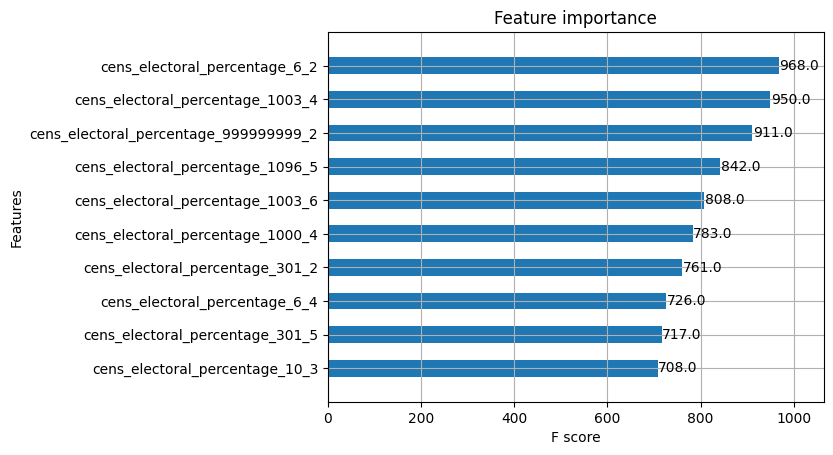

cens_electoral_percentage_10_1
MAE: 7.48
MSE: 66.58
RMSE: 8.16
R2: -0.71


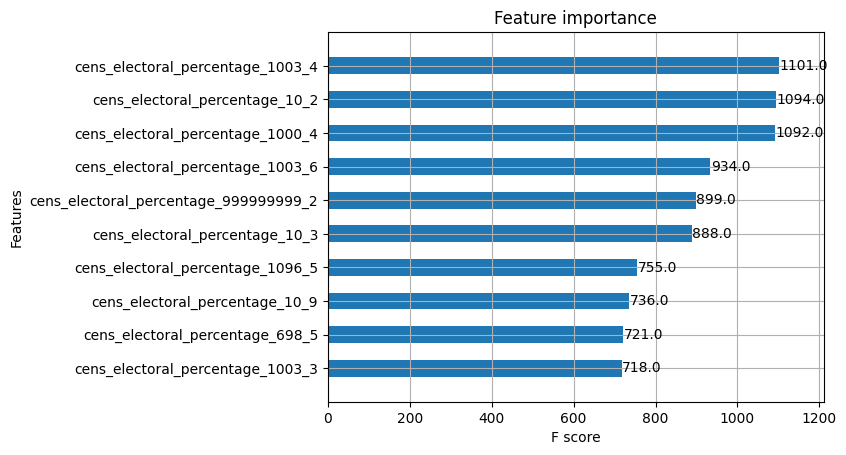

cens_electoral_percentage_86_1
MAE: 5.13
MSE: 33.10
RMSE: 5.75
R2: -9.19


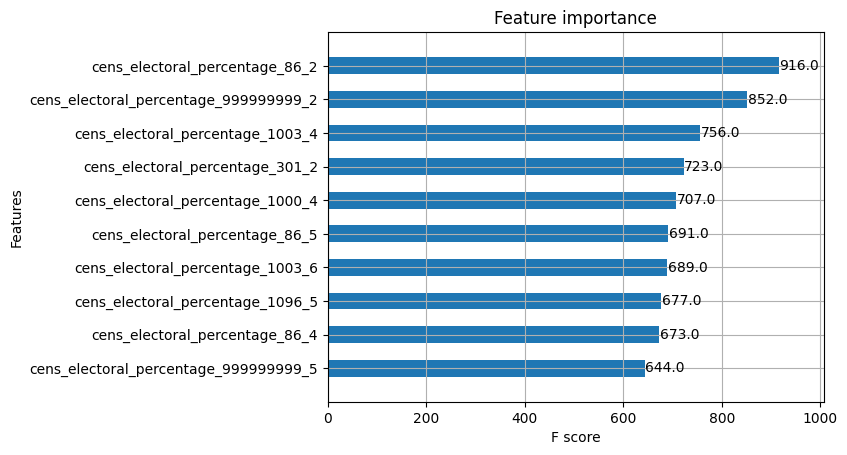

cens_electoral_percentage_301_1
MAE: 14.65
MSE: 267.36
RMSE: 16.35
R2: -2.53


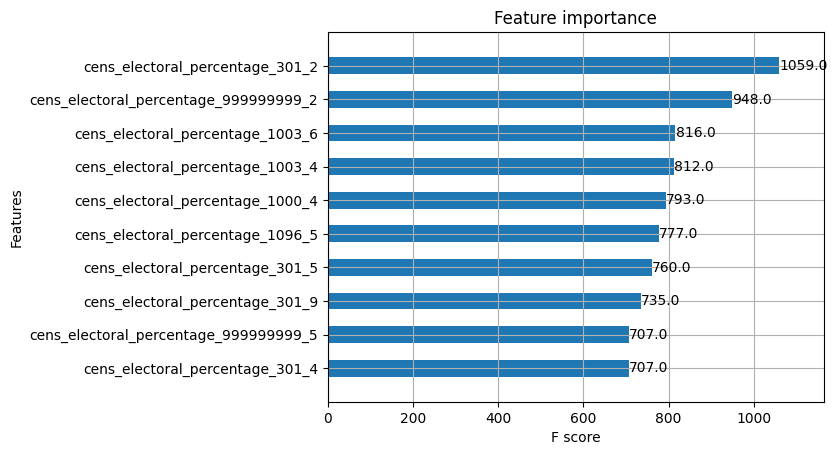

cens_electoral_percentage_412_1
MAE: 1.62
MSE: 3.12
RMSE: 1.77
R2: 0.00


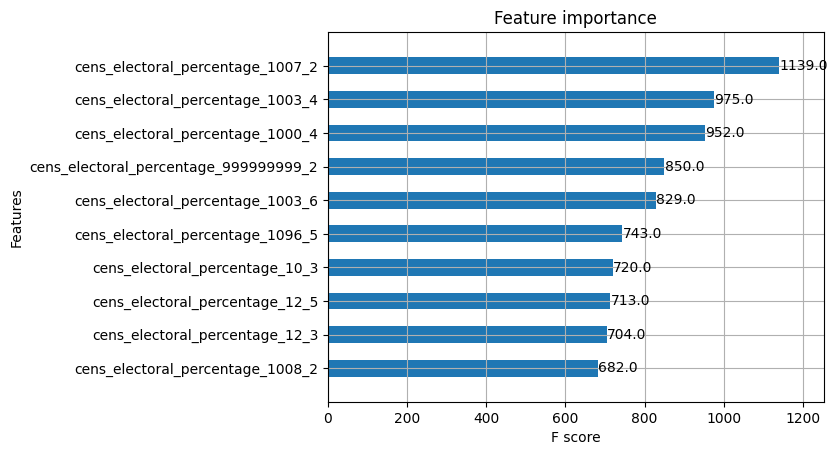

cens_electoral_percentage_1013_1
MAE: 8.38
MSE: 75.89
RMSE: 8.71
R2: 0.00


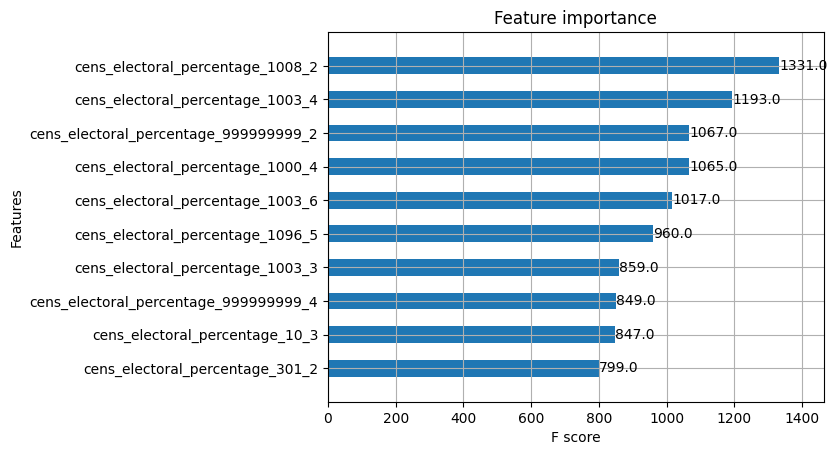

cens_electoral_percentage_999999999_1
MAE: 0.23
MSE: 0.08
RMSE: 0.28
R2: -1.47


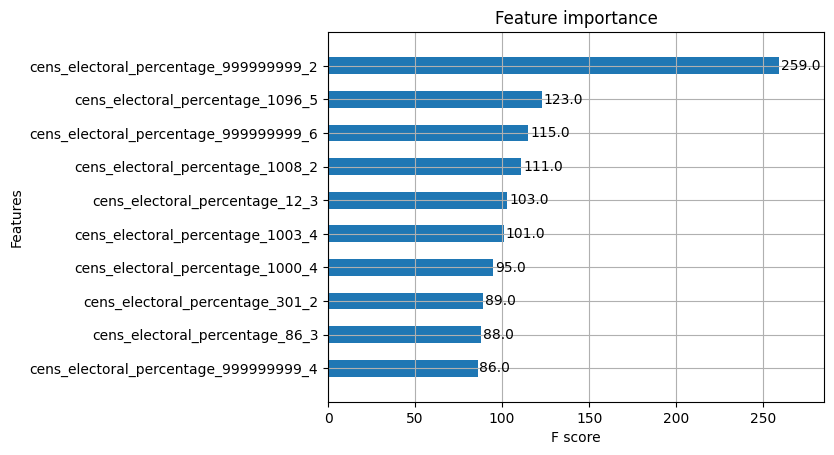

cens_electoral_percentage_1000_1
MAE: 0.00
MSE: 0.00
RMSE: 0.00
R2: 1.00
Error plotting importance: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.
cens_electoral_percentage_1003_1
MAE: 3.82
MSE: 20.07
RMSE: 4.48
R2: -2.68
Error plotting importance: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.
cens_electoral_percentage_1007_1
MAE: 0.00
MSE: 0.00
RMSE: 0.00
R2: 1.00
Error plotting importance: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.
cens_electoral_percentage_1008_1
MAE: 0.00
MSE: 0.00
RMSE: 0.00
R2: 1.00
Error plotting importance: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.
cens_electoral_percentage_1015_1
MAE: 5.77
MSE: 40.95
RMSE: 6.40
R2: -4.35
Error plotting importance: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.
cens_electoral_p

In [51]:
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def train_and_test_xgboost(
    X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Trains an XGBoost model on the training set and evaluates it on the testing set.

    Args:
        X_train (pd.DataFrame): The training features dataframe.
        X_test (pd.DataFrame): The testing features dataframe.
        y_train (pd.Series): The target variable for the training set.
        y_test (pd.Series): The target variable for the testing set.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing the predicted values and the true values for the testing set.
    """
    # Sort X_train and X_test columns to match
    X_train = X_train.reindex(sorted(X_train.columns), axis=1)
    X_test = X_test.reindex(sorted(X_test.columns), axis=1)

    # Convert to float type
    X_train = X_train.astype(float)
    X_test = X_test.astype(float)
    y_train = y_train.astype(float)
    y_test = y_test.astype(float)
    
    # Define the XGBoost model
    xgb = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        random_state=42
    )

    
    # Train an XGBoost model
    xgb.fit(X_train, y_train)

    # Predict the target variable on the testing set
    y_pred = xgb.predict(X_test)
    
    # Print mae, mse, rmse and R2
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.2f}")
    
    # Plot feature importance
    try:
        plot_importance(xgb, importance_type='weight', max_num_features=10, height=0.5)
        plt.show()
    except Exception as e:
        print(f"Error plotting importance: {e}")
    
    return y_pred, y_test.values

# Assuming X_train, X_test, y_train, y_test are defined somewhere earlier in the code.
for column in y_train.columns:
    print(column)
    train_and_test_xgboost(X_train, X_test, y_train[column], y_test[column])


In [77]:
import xgboost as xgb

# Sort X_train and X_test columns to match
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

# Convert to float type
X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Create DMatrix objects for training and testing
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [100]:
# Parameters specific to the multi-target regression task
params = {
    "objective": "reg:squarederror",  # Squared error regression objective
    "max_depth": 6,                  # Depth of each tree
    "eta": 0.1,                       # Learning rate
    "num_parallel_tree": 1            # Number of parallel trees (boosting round)
}

### Model training

In [101]:
# Train the model
num_boost_round = 50
model = xgb.train(params, dtrain, num_boost_round)

### Model evaluation

In [55]:
print(f"Train shape: {dtrain.num_row()}, {dtrain.num_col()}")

Train shape: 5083, 1040


In [56]:
print(f"Test shape: {dtest.num_row()}, {dtest.num_col()}")

Test shape: 5083, 1040


In [102]:
# Predict the targets for the test data
y_pred = model.predict(dtest)

In [80]:
y_pred.shape

(5083, 26)

In [103]:
# Convert the predictions to a DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns, index=y_test.index)

y_pred_df.head()

,cens_electoral_percentage_6_1,cens_electoral_percentage_10_1,cens_electoral_percentage_86_1,cens_electoral_percentage_301_1,cens_electoral_percentage_1003_1,cens_electoral_percentage_1015_1,cens_electoral_percentage_1016_1,cens_electoral_percentage_999999999_1,cens_electoral_percentage_1000_1,cens_electoral_percentage_1007_1,...,cens_electoral_percentage_201914111_1,cens_electoral_percentage_2019838_1,cens_electoral_percentage_237_1,cens_electoral_percentage_337_1,cens_electoral_percentage_412_1,cens_electoral_percentage_4_1,cens_electoral_percentage_5000000_1,cens_electoral_percentage_693_1,cens_electoral_percentage_698_1,cens_electoral_percentage_82484191_1
MUNDISSEC,,,,,,,,,,,,,,,,,,,,,
08001801001,11.553595,1.925593,8.440062,12.559790,0.831666,-0.001009,1.856684,0.854065,3.225167e-23,3.225167e-23,...,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23
08001801002,16.446320,1.510569,9.161497,13.493670,0.792208,-0.001077,1.781733,0.919585,3.225167e-23,3.225167e-23,...,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23
08001801003,9.924475,1.444658,6.360070,13.083907,7.268560,0.006292,1.699484,0.902952,3.225167e-23,3.225167e-23,...,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23
08001801004,9.439028,1.924427,6.005528,12.699845,3.087806,0.005965,1.504035,0.931503,3.225167e-23,3.225167e-23,...,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23
08001801005,16.231367,1.358685,8.466133,13.384112,0.738957,0.002172,1.833978,0.752349,3.225167e-23,3.225167e-23,...,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23,3.225167e-23


In [105]:
y_test.head()

,cens_electoral_percentage_6_1,cens_electoral_percentage_10_1,cens_electoral_percentage_86_1,cens_electoral_percentage_301_1,cens_electoral_percentage_1003_1,cens_electoral_percentage_1015_1,cens_electoral_percentage_1016_1,cens_electoral_percentage_999999999_1,cens_electoral_percentage_1000_1,cens_electoral_percentage_1007_1,...,cens_electoral_percentage_201914111_1,cens_electoral_percentage_2019838_1,cens_electoral_percentage_237_1,cens_electoral_percentage_337_1,cens_electoral_percentage_412_1,cens_electoral_percentage_4_1,cens_electoral_percentage_5000000_1,cens_electoral_percentage_693_1,cens_electoral_percentage_698_1,cens_electoral_percentage_82484191_1
MUNDISSEC,,,,,,,,,,,,,,,,,,,,,
08001801001,17.688266,17.688266,4.816112,25.043783,2.451839,7.793345,8.756567,0.700525,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08001801002,18.591772,12.737342,4.351266,26.819620,1.977848,9.651899,8.465190,0.632911,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08001801003,17.719298,17.543860,1.403509,29.298246,1.403509,8.245614,11.403509,0.526316,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08001801004,15.680473,19.378698,3.328402,27.440828,2.292899,8.505917,8.579882,0.665680,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08001801005,17.363112,12.608069,4.250720,30.187320,2.089337,9.365994,5.115274,0.480307,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
def parse_column_name(column_name: str, variable_name: str = "cens_electoral_percentage"):
    """
    Parse the column name to extract party code, election type, year, and repetition.

    Args:
        column_name (str): Column name formatted as `VARIABLE_PARTYCODE_ELECTIONSCODE`.
        variable_name (str): The prefix used in the column name.

    Returns:
        dict: A dictionary containing parsed components: party_code, election_type, election_year, election_repetition.
    """
    # Dynamic regex pattern using the provided variable name
    pattern = rf"{re.escape(variable_name)}_(\d+)_(\d+)"

    # Use regex to find all elements
    match = re.match(pattern, column_name)

    if match:
        return {
            'party_code': match.group(1),
            'election_id': match.group(2),
        }
    else:
        raise ValueError(f"Invalid column name format: {column_name}")

In [106]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Ensure y_test and y_pred are NumPy arrays
y_test_np = y_test.values if isinstance(y_test, pd.DataFrame) else np.array(y_test)
y_pred_np = y_pred.values if isinstance(y_pred, pd.DataFrame) else np.array(y_pred)

# Retrieve the column names from the DataFrame (y_test)
columns = y_test.columns

# Initialize lists to hold metrics for each target
mae = []
mse = []
rmse = []
r2 = []

# Calculate metrics for each target column
for i in range(y_test_np.shape[1]):
    mae.append(mean_absolute_error(y_test_np[:, i], y_pred_np[:, i]))
    mse.append(mean_squared_error(y_test_np[:, i], y_pred_np[:, i]))
    rmse.append(np.sqrt(mse[i]))
    r2.append(r2_score(y_test_np[:, i], y_pred_np[:, i]))

    # Extract the party code from the column name using the parse function
    parsed_info = parse_column_name(columns[i])

    # Display results for each target
    print(f"Target {i+1} (Party Code: {parsed_info['party_code']}):")
    print(f" - MAE: {mae[i]:.4f}")
    print(f" - MSE: {mse[i]:.4f}")
    print(f" - RMSE: {rmse[i]:.4f}")
    print(f" - R²: {r2[i]:.4f}")
    print()


Target 1 (Party Code: 6):
 - MAE: 2.7156
 - MSE: 11.4359
 - RMSE: 3.3817
 - R²: 0.5485

Target 2 (Party Code: 10):
 - MAE: 16.0301
 - MSE: 295.0974
 - RMSE: 17.1784
 - R²: -6.6004

Target 3 (Party Code: 86):
 - MAE: 3.6575
 - MSE: 19.5358
 - RMSE: 4.4199
 - R²: -5.0150

Target 4 (Party Code: 301):
 - MAE: 10.7857
 - MSE: 142.6633
 - RMSE: 11.9442
 - R²: -0.8832

Target 5 (Party Code: 1003):
 - MAE: 4.5744
 - MSE: 30.7160
 - RMSE: 5.5422
 - R²: -4.6392

Target 6 (Party Code: 1015):
 - MAE: 5.7629
 - MSE: 40.8968
 - RMSE: 6.3951
 - R²: -4.3457

Target 7 (Party Code: 1016):
 - MAE: 17.1383
 - MSE: 449.7528
 - RMSE: 21.2074
 - R²: -1.9612

Target 8 (Party Code: 999999999):
 - MAE: 0.4090
 - MSE: 0.2009
 - RMSE: 0.4483
 - R²: -5.4903

Target 9 (Party Code: 1000):
 - MAE: 0.0000
 - MSE: 0.0000
 - RMSE: 0.0000
 - R²: 0.0000

Target 10 (Party Code: 1007):
 - MAE: 0.0000
 - MSE: 0.0000
 - RMSE: 0.0000
 - R²: 0.0000

Target 11 (Party Code: 1008):
 - MAE: 0.0000
 - MSE: 0.0000
 - RMSE: 0.0000
 - 

## PyCaret Experimentation

PyCaret is a low-code machine learning library that allows you to go from preparing your data to deploying your model within minutes in your choice of notebook environment.

In [90]:
target_list = y_train.columns.tolist()

In [89]:
df_filtered = df_filtered.astype(float)

In [91]:
from pycaret.regression import RegressionExperiment

s = RegressionExperiment()
s.setup(df_filtered, target = target_list[0], session_id = 123)

ValueError: Invalid value for the target parameter. Column cens_electoral_percentage_6_1 not found in the data.

In [43]:
# compare models
best = s.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.1165,2.2370,1.4944,0.9003,0.1517,0.1182,0.5150
et,Extra Trees Regressor,1.1369,2.3076,1.5178,0.8973,0.1477,0.1193,2.3250
gbr,Gradient Boosting Regressor,1.1389,2.3665,1.5361,0.8947,0.1545,0.1213,4.3000
br,Bayesian Ridge,1.1487,2.5153,1.5801,0.8874,0.1595,0.1226,0.0620
rf,Random Forest Regressor,1.1869,2.5264,1.5875,0.8873,0.1530,0.1243,7.4330
ridge,Ridge Regression,1.1776,2.5593,1.5956,0.8855,0.1648,0.1266,0.0440
lr,Linear Regression,1.1815,2.5775,1.6013,0.8847,0.1660,0.1271,0.5500
xgboost,Extreme Gradient Boosting,1.1984,2.6025,1.6112,0.8841,0.1608,0.1249,1.2390
huber,Huber Regressor,1.1325,2.7668,1.6491,0.8760,0.1750,0.1186,0.3010
omp,Orthogonal Matching Pursuit,1.2285,2.9056,1.6935,0.8701,0.1656,0.1290,0.0410


In [44]:
print(best)

LGBMRegressor(n_jobs=-1, random_state=123)


In [45]:
# analyze the best model
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [46]:
for target in target_list:
    s = RegressionExperiment()
    s.setup(df_filtered, target = target, session_id = 123)
    best = s.compare_models()
    print(best)

,Description,Value
0,Session id,123
1,Target,cens_electoral_percentage_6_A20211
2,Target type,Regression
3,Original data shape,"(5083, 347)"
4,Transformed data shape,"(5083, 347)"
5,Transformed train set shape,"(3558, 347)"
6,Transformed test set shape,"(1525, 347)"
7,Numeric features,346
8,Rows with missing values,1.8%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.1165,2.2370,1.4944,0.9003,0.1517,0.1182,0.5210
et,Extra Trees Regressor,1.1369,2.3076,1.5178,0.8973,0.1477,0.1193,2.3000
gbr,Gradient Boosting Regressor,1.1389,2.3665,1.5361,0.8947,0.1545,0.1213,4.2560
br,Bayesian Ridge,1.1487,2.5153,1.5801,0.8874,0.1595,0.1226,0.0600
rf,Random Forest Regressor,1.1869,2.5264,1.5875,0.8873,0.1530,0.1243,6.5990
ridge,Ridge Regression,1.1776,2.5593,1.5956,0.8855,0.1648,0.1266,0.0400
lr,Linear Regression,1.1815,2.5775,1.6013,0.8847,0.1660,0.1271,0.5080
xgboost,Extreme Gradient Boosting,1.1984,2.6025,1.6112,0.8841,0.1608,0.1249,1.2230
huber,Huber Regressor,1.1325,2.7668,1.6491,0.8760,0.1750,0.1186,0.3080
omp,Orthogonal Matching Pursuit,1.2285,2.9056,1.6935,0.8701,0.1656,0.1290,0.0400


LGBMRegressor(n_jobs=-1, random_state=123)


,Description,Value
0,Session id,123
1,Target,cens_electoral_percentage_10_A20211
2,Target type,Regression
3,Original data shape,"(5083, 347)"
4,Transformed data shape,"(5083, 347)"
5,Transformed train set shape,"(3558, 347)"
6,Transformed test set shape,"(1525, 347)"
7,Numeric features,346
8,Rows with missing values,1.8%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.0371,2.3111,1.5153,0.8861,0.1204,0.1029,2.3470
gbr,Gradient Boosting Regressor,1.0486,2.3131,1.5168,0.8858,0.1242,0.1068,4.5080
lightgbm,Light Gradient Boosting Machine,1.0502,2.3317,1.5211,0.8850,0.1222,0.1040,0.6170
rf,Random Forest Regressor,1.0767,2.5218,1.5811,0.8757,0.1257,0.1071,6.8000
xgboost,Extreme Gradient Boosting,1.1088,2.5959,1.6057,0.8723,0.1291,0.1102,1.3410
omp,Orthogonal Matching Pursuit,1.1110,2.6844,1.6289,0.8677,0.1324,0.1095,0.0400
en,Elastic Net,1.1156,2.7152,1.6425,0.8661,0.1421,0.1122,0.0420
huber,Huber Regressor,1.0751,2.8191,1.6619,0.8614,0.1581,0.1047,0.3290
br,Bayesian Ridge,1.0963,2.8400,1.6532,0.8608,0.1311,0.1089,0.0550
llar,Lasso Least Angle Regression,1.1658,2.9133,1.7025,0.8563,0.1526,0.1195,0.0390


ExtraTreesRegressor(n_jobs=-1, random_state=123)


,Description,Value
0,Session id,123
1,Target,cens_electoral_percentage_86_A20211
2,Target type,Regression
3,Original data shape,"(5083, 347)"
4,Transformed data shape,"(5083, 347)"
5,Transformed train set shape,"(3558, 347)"
6,Transformed test set shape,"(1525, 347)"
7,Numeric features,346
8,Rows with missing values,1.8%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.4418,0.3678,0.6045,0.8214,0.2050,0.3007,2.3140
rf,Random Forest Regressor,0.4453,0.3824,0.6158,0.8145,0.2049,0.3001,7.3800
gbr,Gradient Boosting Regressor,0.4465,0.3828,0.6162,0.8140,0.2079,0.2983,4.3300
lightgbm,Light Gradient Boosting Machine,0.4502,0.3950,0.6253,0.8113,0.2084,0.3003,0.4910
xgboost,Extreme Gradient Boosting,0.4713,0.4331,0.6558,0.7889,0.2195,0.3174,1.0880
br,Bayesian Ridge,0.4713,0.4422,0.6608,0.7833,0.2240,0.3121,0.0660
omp,Orthogonal Matching Pursuit,0.4885,0.4622,0.6772,0.7769,0.2300,0.3197,0.0550
ridge,Ridge Regression,0.4832,0.4690,0.6798,0.7658,0.2314,0.3237,0.0450
lr,Linear Regression,0.4846,0.4712,0.6813,0.7648,0.2321,0.3247,0.0540
huber,Huber Regressor,0.4883,0.4864,0.6914,0.7562,0.2345,0.3303,0.3260


ExtraTreesRegressor(n_jobs=-1, random_state=123)


,Description,Value
0,Session id,123
1,Target,cens_electoral_percentage_301_A20211
2,Target type,Regression
3,Original data shape,"(5083, 347)"
4,Transformed data shape,"(5083, 347)"
5,Transformed train set shape,"(3558, 347)"
6,Transformed test set shape,"(1525, 347)"
7,Numeric features,346
8,Rows with missing values,1.8%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.5186,0.4604,0.6780,0.7871,0.1995,0.2578,2.3140
rf,Random Forest Regressor,0.5218,0.4677,0.6833,0.7833,0.2011,0.2577,6.6870
gbr,Gradient Boosting Regressor,0.5208,0.4679,0.6836,0.7828,0.2037,0.2571,5.9410
lightgbm,Light Gradient Boosting Machine,0.5233,0.4718,0.6863,0.7813,0.2012,0.2556,5.4670
br,Bayesian Ridge,0.5351,0.4987,0.7053,0.7692,0.2131,0.2692,0.0690
ridge,Ridge Regression,0.5493,0.5190,0.7196,0.7598,0.2198,0.2766,0.0450
lr,Linear Regression,0.5505,0.5213,0.7212,0.7587,0.2203,0.2775,0.0490
ada,AdaBoost Regressor,0.5715,0.5288,0.7270,0.7545,0.2283,0.3194,1.7850
xgboost,Extreme Gradient Boosting,0.5595,0.5345,0.7306,0.7525,0.2149,0.2743,5.6360
omp,Orthogonal Matching Pursuit,0.5475,0.5346,0.7294,0.7520,0.2142,0.2739,0.0520


ExtraTreesRegressor(n_jobs=-1, random_state=123)


,Description,Value
0,Session id,123
1,Target,cens_electoral_percentage_693_A20211
2,Target type,Regression
3,Original data shape,"(5083, 347)"
4,Transformed data shape,"(5083, 347)"
5,Transformed train set shape,"(3558, 347)"
6,Transformed test set shape,"(1525, 347)"
7,Numeric features,346
8,Rows with missing values,1.8%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.6252,0.7010,0.8369,0.8109,0.1974,0.2129,8.6900
rf,Random Forest Regressor,0.6306,0.7106,0.8427,0.8084,0.1986,0.2143,23.8090
lightgbm,Light Gradient Boosting Machine,0.6332,0.7115,0.8432,0.8078,0.1982,0.2128,0.5630
gbr,Gradient Boosting Regressor,0.6390,0.7213,0.8490,0.8052,0.2037,0.2193,9.2620
br,Bayesian Ridge,0.6437,0.7807,0.8810,0.7878,0.2060,0.2247,0.1420
omp,Orthogonal Matching Pursuit,0.6587,0.7954,0.8907,0.7846,0.2100,0.2264,0.0950
xgboost,Extreme Gradient Boosting,0.6744,0.8215,0.9057,0.7780,0.2129,0.2290,1.3260
huber,Huber Regressor,0.6560,0.8279,0.9075,0.7750,0.2142,0.2247,0.6220
ridge,Ridge Regression,0.6584,0.8573,0.9215,0.7657,0.2130,0.2305,0.0940
lr,Linear Regression,0.6602,0.8635,0.9246,0.7639,0.2138,0.2312,0.1120


ExtraTreesRegressor(n_jobs=-1, random_state=123)


,Description,Value
0,Session id,123
1,Target,cens_electoral_percentage_1031_A20211
2,Target type,Regression
3,Original data shape,"(5083, 347)"
4,Transformed data shape,"(5083, 347)"
5,Transformed train set shape,"(3558, 347)"
6,Transformed test set shape,"(1525, 347)"
7,Numeric features,346
8,Rows with missing values,1.8%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,1.0028,2.8166,1.6635,0.9558,0.1477,0.1459,9.9000
et,Extra Trees Regressor,1.0023,2.8523,1.6794,0.9549,0.1408,0.1275,7.9360
lightgbm,Light Gradient Boosting Machine,1.0010,2.9481,1.7017,0.9536,0.1440,0.1329,5.6030
rf,Random Forest Regressor,1.0280,3.1542,1.7591,0.9505,0.1436,0.1303,22.1930
xgboost,Extreme Gradient Boosting,1.0868,3.3533,1.8171,0.9471,0.1507,0.1392,7.7720
en,Elastic Net,1.0626,3.3508,1.8214,0.9470,0.1685,0.1427,0.1130
huber,Huber Regressor,1.0350,3.3849,1.8238,0.9463,0.1939,0.1364,0.5780
omp,Orthogonal Matching Pursuit,1.0962,3.3864,1.8312,0.9461,0.1729,0.1538,0.0980
br,Bayesian Ridge,1.0764,3.4082,1.8226,0.9458,0.1732,0.1552,0.1470
ridge,Ridge Regression,1.0821,3.4194,1.7802,0.9458,0.1866,0.1751,0.0940


GradientBoostingRegressor(random_state=123)


,Description,Value
0,Session id,123
1,Target,cens_electoral_percentage_1099_A20211
2,Target type,Regression
3,Original data shape,"(5083, 347)"
4,Transformed data shape,"(5083, 347)"
5,Transformed train set shape,"(3558, 347)"
6,Transformed test set shape,"(1525, 347)"
7,Numeric features,346
8,Rows with missing values,1.8%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.5816,0.6079,0.7767,0.8110,0.1996,0.2184,8.8090
gbr,Gradient Boosting Regressor,0.5864,0.6283,0.7894,0.8046,0.2024,0.2180,10.1150
rf,Random Forest Regressor,0.5919,0.6295,0.7910,0.8040,0.2009,0.2199,8.9910
lightgbm,Light Gradient Boosting Machine,0.5891,0.6335,0.7932,0.8028,0.2016,0.2159,5.8100
br,Bayesian Ridge,0.6037,0.6497,0.8037,0.7979,0.2130,0.2250,0.0570
xgboost,Extreme Gradient Boosting,0.6232,0.6933,0.8304,0.7840,0.2100,0.2268,6.6500
ridge,Ridge Regression,0.6213,0.6960,0.8315,0.7833,0.2227,0.2304,0.0380
lr,Linear Regression,0.6229,0.6990,0.8333,0.7823,0.2235,0.2309,0.0560
huber,Huber Regressor,0.6226,0.7015,0.8346,0.7818,0.2213,0.2286,0.3100
omp,Orthogonal Matching Pursuit,0.6330,0.7432,0.8578,0.7694,0.2205,0.2350,0.0390


ExtraTreesRegressor(n_jobs=-1, random_state=123)


,Description,Value
0,Session id,123
1,Target,cens_electoral_percentage_2019838_A20211
2,Target type,Regression
3,Original data shape,"(5083, 347)"
4,Transformed data shape,"(5083, 347)"
5,Transformed train set shape,"(3558, 347)"
6,Transformed test set shape,"(1525, 347)"
7,Numeric features,346
8,Rows with missing values,1.8%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.6042,0.8700,0.9280,0.8755,0.1817,0.2209,2.2040
rf,Random Forest Regressor,0.6130,0.9583,0.9713,0.8627,0.1872,0.2273,13.5580
gbr,Gradient Boosting Regressor,0.6185,0.9616,0.9744,0.8626,0.1888,0.2322,3.5930
lightgbm,Light Gradient Boosting Machine,0.6142,0.9633,0.9761,0.8625,0.1880,0.2257,0.7530
omp,Orthogonal Matching Pursuit,0.6388,0.9894,0.9851,0.8585,0.1990,0.2303,0.0900
br,Bayesian Ridge,0.6562,0.9989,0.9918,0.8575,0.2056,0.2420,0.1370
xgboost,Extreme Gradient Boosting,0.6370,1.0120,1.0014,0.8555,0.1946,0.2345,1.3930
huber,Huber Regressor,0.6571,1.0247,1.0052,0.8535,0.2099,0.2361,0.5900
en,Elastic Net,0.6621,1.0684,1.0290,0.8472,0.1987,0.2374,0.0940
ridge,Ridge Regression,0.6856,1.0760,1.0293,0.8465,0.2182,0.2589,0.0950


ExtraTreesRegressor(n_jobs=-1, random_state=123)


,Description,Value
0,Session id,123
1,Target,cens_electoral_percentage_999999999_A20211
2,Target type,Regression
3,Original data shape,"(5083, 347)"
4,Transformed data shape,"(5083, 347)"
5,Transformed train set shape,"(3558, 347)"
6,Transformed test set shape,"(1525, 347)"
7,Numeric features,346
8,Rows with missing values,1.8%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0857,0.0231,0.1502,0.5831,0.0928,0.3628,0.6140
et,Extra Trees Regressor,0.0864,0.0241,0.1530,0.5684,0.0941,0.3728,2.6960
xgboost,Extreme Gradient Boosting,0.0897,0.0243,0.1546,0.5592,0.0964,0.3777,1.4600
rf,Random Forest Regressor,0.0872,0.0245,0.1550,0.5588,0.0955,0.3787,7.9510
br,Bayesian Ridge,0.0951,0.0246,0.1554,0.5546,0.0986,0.4250,0.0510
gbr,Gradient Boosting Regressor,0.0883,0.0257,0.1583,0.5398,0.0966,0.3812,4.0830
omp,Orthogonal Matching Pursuit,0.0985,0.0256,0.1586,0.5361,0.1005,0.4447,0.0280
ridge,Ridge Regression,0.1002,0.0259,0.1595,0.5301,0.1025,0.4580,0.0290
lr,Linear Regression,0.1005,0.0260,0.1600,0.5274,0.1028,0.4599,0.0370
knn,K Neighbors Regressor,0.0943,0.0270,0.1618,0.5174,0.1004,0.4024,0.0390


LGBMRegressor(n_jobs=-1, random_state=123)
